# Collect Tweets into MongoDB

## Install Python libraries

You may need to restart your Jupyter Notebook instance after installed those libraries.

In [1]:
!pip install pymongo

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [2]:
!pip install pymongo[srv]

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [3]:
!pip install dnspython

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [4]:
!pip install tweepy

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [5]:
!pip install twitter

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


## Import Python libraries

In [6]:
import pymongo
from pymongo import MongoClient
import json
import tweepy
import twitter
from pprint import pprint
import configparser
import pandas as pd

##  Load the Authorization Info

Save database connection info and API Keys in a config.ini file and use the configparse to load the authorization info. 

In [7]:
config = configparser.ConfigParser()
config.read('config.ini')

CONSUMER_KEY      = config['mytwitter']['api_key']
CONSUMER_SECRET   = config['mytwitter']['api_secret']
OAUTH_TOKEN       = config['mytwitter']['access_token']
OATH_TOKEN_SECRET = config['mytwitter']['access_secret']

mongod_connect = config['mymongo']['connection']

## Connect to the MongoDB Cluster

In [8]:
client = MongoClient(mongod_connect)
db = client.gp16 # use or create a database named demo
tweet_collection = db.final #use or create a collection named tweet_collection
tweet_collection.create_index([("id", pymongo.ASCENDING)],unique = True) # make sure the collected tweets are unique

'id_1'

## Use the Streaming API to Collect Tweets

Authorize the Stream API 

In [9]:
stream_auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
stream_auth.set_access_token(OAUTH_TOKEN, OATH_TOKEN_SECRET)

strem_api = tweepy.API(stream_auth)

Define the query for the Stream API

In [5]:
track = ['election'] # define the keywords, tweets contain election

locations = [-78.9326449,38.4150904,-78.8816972,38.4450731] #defin the location, in Harrisonburg, VA

The collected tweets will contain 'election' <span style="color:red;font-weight:bold"> OR </span> are located in Harrisonburg, VA

In [ ]:
class MyStreamListener(tweepy.StreamListener):
    def on_status(self, status):
        print (status.id_str)
        try:
            tweet_collection.insert_one(status._json)
        except:
            pass
  
    def on_error(self, status_code):
        if status_code == 420:
            #returning False in on_data disconnects the stream
            return False
myStreamListener = MyStreamListener()
myStream = tweepy.Stream(auth = strem_api.auth, listener=myStreamListener)
myStream.filter(track=track)#  (locations = locations)   #Use either track or locations

## Use the REST API to Collect Tweets

Authorize the REST API 

In [9]:
rest_auth = twitter.oauth.OAuth(OAUTH_TOKEN,OATH_TOKEN_SECRET,CONSUMER_KEY,CONSUMER_SECRET)
rest_api = twitter.Twitter(auth=rest_auth)

Define the query for the REST API

In [10]:
count = 100 #number of returned tweets, default and max is 100
geocode = "36.6870,-105.9378,100mi"  # defin the location, in Santa Fe, NM
q = "COVID-19"                               #define the keywords, tweets contain election

The collected tweets will contain 'COVID-19' <span style="color:red;font-weight:bold"> AND </span> are located in Santa Fe, NM

In [11]:
search_results = rest_api.search.tweets( count=count,q=q, geocode=geocode) #you can use both q and geocode
statuses = search_results["statuses"]
since_id_new = statuses[-1]['id']
for statuse in statuses:
    try:
        tweet_collection.insert_one(statuse)
        pprint(statuse['created_at'])# print the date of the collected tweets
    except:
        pass

'Thu Dec 17 23:01:35 +0000 2020'
'Thu Dec 17 22:49:34 +0000 2020'
'Thu Dec 17 22:47:23 +0000 2020'
'Thu Dec 17 22:41:27 +0000 2020'
'Thu Dec 17 22:33:49 +0000 2020'
'Thu Dec 17 22:29:42 +0000 2020'
'Thu Dec 17 22:04:59 +0000 2020'
'Thu Dec 17 21:16:25 +0000 2020'
'Thu Dec 17 21:14:07 +0000 2020'
'Thu Dec 17 21:14:04 +0000 2020'
'Thu Dec 17 21:04:31 +0000 2020'
'Thu Dec 17 21:01:36 +0000 2020'
'Thu Dec 17 20:58:35 +0000 2020'
'Thu Dec 17 20:35:34 +0000 2020'
'Thu Dec 17 20:13:26 +0000 2020'
'Thu Dec 17 20:07:43 +0000 2020'
'Thu Dec 17 19:48:33 +0000 2020'
'Thu Dec 17 19:44:58 +0000 2020'
'Thu Dec 17 19:31:28 +0000 2020'
'Thu Dec 17 19:28:47 +0000 2020'
'Thu Dec 17 19:09:41 +0000 2020'
'Thu Dec 17 19:02:58 +0000 2020'
'Thu Dec 17 18:48:33 +0000 2020'
'Thu Dec 17 18:47:26 +0000 2020'
'Thu Dec 17 18:40:10 +0000 2020'
'Thu Dec 17 18:34:17 +0000 2020'
'Thu Dec 17 18:26:57 +0000 2020'
'Thu Dec 17 18:26:51 +0000 2020'
'Thu Dec 17 18:15:55 +0000 2020'
'Thu Dec 17 18:14:47 +0000 2020'
'Thu Dec 1

Continue fetching early tweets with the same query. 
<p><span style="color:red;font-weight:bold">YOU WILL REACH YOUR RATE LIMIT VERY FAST</span></p>

In [12]:
since_id_old = 0
while(since_id_new != since_id_old):
    since_id_old = since_id_new
    search_results = rest_api.search.tweets( count=count,q=q,
                        geocode=geocode, max_id= since_id_new)
    statuses = search_results["statuses"]
    since_id_new = statuses[-1]['id']
    for statuse in statuses:
        try:
            tweet_collection.insert_one(statuse)
            pprint(statuse['created_at']) # print the date of the collected tweets
        except:
            pass

'Thu Dec 17 14:11:59 +0000 2020'
'Thu Dec 17 14:10:41 +0000 2020'
'Thu Dec 17 14:05:43 +0000 2020'
'Thu Dec 17 14:02:37 +0000 2020'
'Thu Dec 17 14:02:07 +0000 2020'
'Thu Dec 17 13:58:18 +0000 2020'
'Thu Dec 17 13:57:04 +0000 2020'
'Thu Dec 17 13:52:46 +0000 2020'
'Thu Dec 17 13:50:44 +0000 2020'
'Thu Dec 17 13:44:38 +0000 2020'
'Thu Dec 17 13:41:50 +0000 2020'
'Thu Dec 17 13:41:27 +0000 2020'
'Thu Dec 17 13:38:44 +0000 2020'
'Thu Dec 17 13:36:04 +0000 2020'
'Thu Dec 17 13:33:23 +0000 2020'
'Thu Dec 17 13:31:49 +0000 2020'
'Thu Dec 17 13:30:25 +0000 2020'
'Thu Dec 17 13:29:42 +0000 2020'
'Thu Dec 17 13:28:24 +0000 2020'
'Thu Dec 17 13:26:29 +0000 2020'
'Thu Dec 17 13:25:06 +0000 2020'
'Thu Dec 17 13:23:24 +0000 2020'
'Thu Dec 17 13:21:51 +0000 2020'
'Thu Dec 17 13:20:47 +0000 2020'
'Thu Dec 17 13:18:47 +0000 2020'
'Thu Dec 17 13:16:57 +0000 2020'
'Thu Dec 17 13:15:44 +0000 2020'
'Thu Dec 17 13:13:15 +0000 2020'
'Thu Dec 17 13:12:35 +0000 2020'
'Thu Dec 17 13:11:29 +0000 2020'
'Thu Dec 1

'Thu Dec 17 05:48:45 +0000 2020'
'Thu Dec 17 05:47:45 +0000 2020'
'Thu Dec 17 05:47:45 +0000 2020'
'Thu Dec 17 05:47:45 +0000 2020'
'Thu Dec 17 05:47:44 +0000 2020'
'Thu Dec 17 05:46:58 +0000 2020'
'Thu Dec 17 05:45:45 +0000 2020'
'Thu Dec 17 05:45:34 +0000 2020'
'Thu Dec 17 05:44:11 +0000 2020'
'Thu Dec 17 05:42:54 +0000 2020'
'Thu Dec 17 05:40:58 +0000 2020'
'Thu Dec 17 05:40:38 +0000 2020'
'Thu Dec 17 05:39:21 +0000 2020'
'Thu Dec 17 05:38:12 +0000 2020'
'Thu Dec 17 05:36:36 +0000 2020'
'Thu Dec 17 05:36:33 +0000 2020'
'Thu Dec 17 05:36:01 +0000 2020'
'Thu Dec 17 05:35:07 +0000 2020'
'Thu Dec 17 05:34:36 +0000 2020'
'Thu Dec 17 05:34:10 +0000 2020'
'Thu Dec 17 05:34:05 +0000 2020'
'Thu Dec 17 05:33:52 +0000 2020'
'Thu Dec 17 05:31:14 +0000 2020'
'Thu Dec 17 05:31:07 +0000 2020'
'Thu Dec 17 05:30:28 +0000 2020'
'Thu Dec 17 05:30:26 +0000 2020'
'Thu Dec 17 05:29:09 +0000 2020'
'Thu Dec 17 05:28:41 +0000 2020'
'Thu Dec 17 05:28:25 +0000 2020'
'Thu Dec 17 05:28:23 +0000 2020'
'Thu Dec 1

'Thu Dec 17 02:40:06 +0000 2020'
'Thu Dec 17 02:38:08 +0000 2020'
'Thu Dec 17 02:37:03 +0000 2020'
'Thu Dec 17 02:36:42 +0000 2020'
'Thu Dec 17 02:35:56 +0000 2020'
'Thu Dec 17 02:35:04 +0000 2020'
'Thu Dec 17 02:34:11 +0000 2020'
'Thu Dec 17 02:33:29 +0000 2020'
'Thu Dec 17 02:32:55 +0000 2020'
'Thu Dec 17 02:32:13 +0000 2020'
'Thu Dec 17 02:31:20 +0000 2020'
'Thu Dec 17 02:30:54 +0000 2020'
'Thu Dec 17 02:30:07 +0000 2020'
'Thu Dec 17 02:28:12 +0000 2020'
'Thu Dec 17 02:25:47 +0000 2020'
'Thu Dec 17 02:25:19 +0000 2020'
'Thu Dec 17 02:23:57 +0000 2020'
'Thu Dec 17 02:23:53 +0000 2020'
'Thu Dec 17 02:21:54 +0000 2020'
'Thu Dec 17 02:21:51 +0000 2020'
'Thu Dec 17 02:21:06 +0000 2020'
'Thu Dec 17 02:19:05 +0000 2020'
'Thu Dec 17 02:18:28 +0000 2020'
'Thu Dec 17 02:17:46 +0000 2020'
'Thu Dec 17 02:17:02 +0000 2020'
'Thu Dec 17 02:16:43 +0000 2020'
'Thu Dec 17 02:16:35 +0000 2020'
'Thu Dec 17 02:15:51 +0000 2020'
'Thu Dec 17 02:15:08 +0000 2020'
'Thu Dec 17 02:15:01 +0000 2020'
'Thu Dec 1

'Wed Dec 16 19:02:13 +0000 2020'
'Wed Dec 16 19:01:46 +0000 2020'
'Wed Dec 16 19:01:34 +0000 2020'
'Wed Dec 16 19:00:00 +0000 2020'
'Wed Dec 16 18:59:52 +0000 2020'
'Wed Dec 16 18:57:52 +0000 2020'
'Wed Dec 16 18:57:46 +0000 2020'
'Wed Dec 16 18:57:12 +0000 2020'
'Wed Dec 16 18:56:10 +0000 2020'
'Wed Dec 16 18:54:06 +0000 2020'
'Wed Dec 16 18:52:40 +0000 2020'
'Wed Dec 16 18:52:13 +0000 2020'
'Wed Dec 16 18:51:18 +0000 2020'
'Wed Dec 16 18:50:56 +0000 2020'
'Wed Dec 16 18:50:34 +0000 2020'
'Wed Dec 16 18:49:36 +0000 2020'
'Wed Dec 16 18:48:43 +0000 2020'
'Wed Dec 16 18:47:41 +0000 2020'
'Wed Dec 16 18:47:36 +0000 2020'
'Wed Dec 16 18:45:01 +0000 2020'
'Wed Dec 16 18:44:57 +0000 2020'
'Wed Dec 16 18:44:45 +0000 2020'
'Wed Dec 16 18:44:42 +0000 2020'
'Wed Dec 16 18:44:36 +0000 2020'
'Wed Dec 16 18:41:40 +0000 2020'
'Wed Dec 16 18:40:42 +0000 2020'
'Wed Dec 16 18:40:32 +0000 2020'
'Wed Dec 16 18:39:48 +0000 2020'
'Wed Dec 16 18:38:43 +0000 2020'
'Wed Dec 16 18:38:40 +0000 2020'
'Wed Dec 1

KeyboardInterrupt: 

## View the Collected Tweets

Print the number of tweets and unique twitter users

In [13]:
print(tweet_collection.estimated_document_count())# number of tweets collected

user_cursor = tweet_collection.distinct("user.id")
print (len(user_cursor)) # number of unique Twitter users 

1905
1742


Create a text index and print the Tweets containing specific keywords. 

In [14]:
tweet_collection.create_index([("text", pymongo.TEXT)], name='text_index', default_language='english') # create a text index


'text_index'

Create a cursor to query tweets with the created index

In [15]:
tweet_cursor = tweet_collection.find({"$text": {"$search": "COVID19"}}) # return tweets contain vote

Use pprint to display tweets

In [16]:

for document in tweet_cursor[0:10]: # display the first 10 tweets from the query
    try:
        print ('----')
#         pprint (document) # use pprint to print the entire tweet document
   
        print ('name:', document["user"]["name"]) # user name
        print ('text:', document["text"])         # tweets
    except:
        print ("***error in encoding")
        pass

----
name: Jim O'Donnell
text: @JimmyJenkins #COVID19 ?
----
name: Ranny Levy
text: #COVID19 https://t.co/yJWbbGRic5
----
name: Jim O'Donnell
text: More than 3000 Americans died today from #COVID19
----
name: Ranny Levy
text: #COVID19 https://t.co/lrsbzhoinA
----
name: Ranny Levy
text: #COVID19 https://t.co/Tx5mqikbRZ
----
name: Jim O'Donnell
text: 3000 more Americans dead today from #covid19.
----
name: Elizabeth P.
text: #COVID19 https://t.co/CbGv3vD5Ni
----
name: Ranny Levy
text: #COVID19 https://t.co/MoHmCuqJUJ
----
name: Jim O'Donnell
text: #COVID19 in #Colorado  https://t.co/S10jzASrSm
----
name: Ranny Levy
text: #COVID19 #PenceKnew #TrumpLiedPeopleDied https://t.co/R2cfOdjzEE


In [17]:
tweet_cursor = tweet_collection.find({"$text": {"$search": "COVID19"}}) # return tweets contain vote

Use pandas to display tweets

In [18]:
tweet_df = pd.DataFrame(list(tweet_cursor ))
tweet_df[:10] #display the first 10 tweets

,_id,created_at,id,id_str,text,truncated,entities,metadata,source,in_reply_to_status_id,...,possibly_sensitive,retweeted_status,extended_entities,quoted_status_permalink,quote_count,reply_count,filter_level,timestamp_ms,display_text_range,extended_tweet
0,5fdbe4ccec86c3cdb141b6c5,Thu Dec 17 05:04:28 +0000 2020,1339436276752273408,1339436276752273408,@JimmyJenkins #COVID19 ?,False,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'und', 'result_type': 'r...","<a href=""http://twitter.com/download/iphone"" r...",1.339359e+18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5fdbe53cec86c3cdb141b7ff,Wed Dec 09 15:11:29 +0000 2020,1336689936213295105,1336689936213295105,#COVID19 https://t.co/yJWbbGRic5,False,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'und', 'result_type': 'r...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5fdbe53cec86c3cdb141b7e7,Thu Dec 10 03:48:32 +0000 2020,1336880450141347843,1336880450141347843,More than 3000 Americans died today from #COVID19,False,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5fdbe53bec86c3cdb141b7ac,Fri Dec 11 14:31:23 +0000 2020,1337404620600082435,1337404620600082435,#COVID19 https://t.co/lrsbzhoinA,False,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'und', 'result_type': 'r...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5fdbe53bec86c3cdb141b7ab,Fri Dec 11 14:37:19 +0000 2020,1337406110660116482,1337406110660116482,#COVID19 https://t.co/Tx5mqikbRZ,False,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'und', 'result_type': 'r...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5fdbe53bec86c3cdb141b792,Sat Dec 12 04:14:38 +0000 2020,1337611797143154688,1337611797143154688,3000 more Americans dead today from #covid19.,False,"{'hashtags': [{'text': 'covid19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,5fdbe53aec86c3cdb141b759,Mon Dec 14 13:52:59 +0000 2020,1338482120432308227,1338482120432308227,#COVID19 https://t.co/CbGv3vD5Ni,False,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'und', 'result_type': 'r...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,5fdbe4ccec86c3cdb141b6b8,Thu Dec 17 15:26:50 +0000 2020,1339592900921835526,1339592900921835526,#COVID19 https://t.co/MoHmCuqJUJ,False,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'und', 'result_type': 'r...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,5fdbe53cec86c3cdb141b80b,Wed Dec 09 05:24:52 +0000 2020,1336542306393083910,1336542306393083910,#COVID19 in #Colorado https://t.co/S10jzASrSm,False,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'und', 'result_type': 'r...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,5fdbe53cec86c3cdb141b800,Wed Dec 09 15:10:31 +0000 2020,1336689689332310016,1336689689332310016,#COVID19 #PenceKnew #TrumpLiedPeopleDied https...,False,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'und', 'result_type': 'r...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


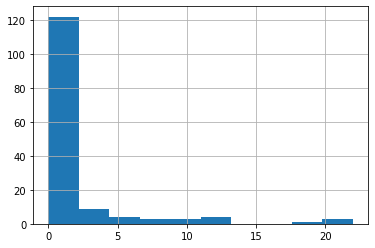

In [19]:
tweet_df["favorite_count"].hist() # create a histogram show the favorite count